In [2]:
import os
import shutil
from glob import glob
from pathlib import Path, PurePath

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model, Sequential

import keras_tuner as kt

In [3]:
train_data_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_data_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'
pred_data_dir = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'

# Hyperparameters

In [4]:
kernel_size_cnn = 3
kernel_size_pool = 2

IMG_WIDTH = 224
IMG_HEIGHT = 224

stride1 = 1
stride2 = 2
padding = 1
batch_size = 128
epochs = 50
ratio = 64
in_channels = 3
hidden_channels1 = 64
hidden_channels2 = 128

# Data Viz

In [5]:
train_df = pd.DataFrame()
name = []
counts = []
for i in os.listdir(train_data_dir):
    name.append(i)
    counts.append(len(os.listdir(train_data_dir+'/'+i)))
train_df['Name'] = name
train_df['Counts'] = counts
train_df.head()

,Name,Counts
0,mountain,2512
1,street,2382
2,buildings,2191
3,sea,2274
4,forest,2271


In [6]:
num_classes = len(train_df.value_counts())

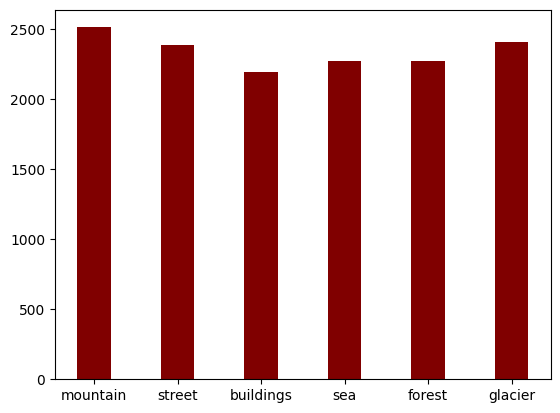

In [7]:
plt.bar(train_df['Name'], train_df['Counts'], color ='maroon',width = 0.4);

In [8]:
test_df = pd.DataFrame()
name = []
counts = []
for i in os.listdir(test_data_dir):
    
    name.append(i)
    counts.append(len(os.listdir(test_data_dir+'/'+i)))
test_df['Name'] = name
test_df['Counts'] = counts
test_df.head()

,Name,Counts
0,mountain,525
1,street,501
2,buildings,437
3,sea,510
4,forest,474


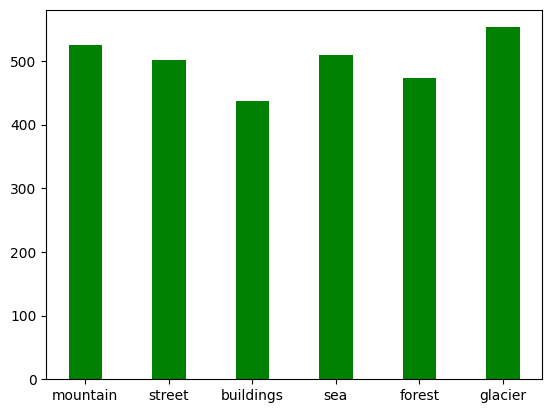

In [9]:
plt.bar(test_df['Name'], test_df['Counts'], color ='green',width = 0.4);

In [10]:
pred_df = pd.DataFrame()
name = []
counts = []
for i in os.listdir(pred_data_dir):
    name.append(i)
#     counts.append(len(os.listdir(pred_data_dir+'/'+i)))
pred_df['Name'] = name
# pred_df['Counts'] = counts
pred_df.head()

,Name
0,6234.jpg
1,22288.jpg
2,20529.jpg
3,21440.jpg
4,5982.jpg


In [11]:
# Plot pred here

## Hparams

In [12]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32


# Train and test Data Generator

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
train_data_gen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_data_gen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

test_data_gen = ImageDataGenerator(
    rescale=1./255.
)

In [15]:
train_gen = train_data_gen.flow_from_directory(
    train_data_dir,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 14034 images belonging to 6 classes.


In [16]:
val_gen = val_data_gen.flow_from_directory(
    test_data_dir,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 3000 images belonging to 6 classes.


In [17]:
# pred_gen = test_data_gen.flow_from_dataframe(
#     pred_df,
#     batch_size=BATCH_SIZE,
#     target_size=(IMG_HEIGHT, IMG_WIDTH)
# )

# callbacks

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="auto",
    patience=5,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    mode='auto',
    verbose=1,
    min_lr=0.0001)

callback_list = [early_stopping, reduce_lr]

# Model Building

In [19]:
import tensorflow
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions,VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [21]:
base_model = VGG16(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights="imagenet"
    )

base_model

58889256/58889256 [==============================] - 2s 0us/step


In [23]:
for i in base_model.layers:
    print(i.)

In [ ]:
def build_model(hp):
    base_model = VGG16(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights="imagenet"
    )
    for layer in base_model.layers[:-1]:
        layer.trainable = False
    x = base_model.output
    x = layers.Flatten()(x)
    x = tensorflow.keras.layers.Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs=base_model.input, outputs=x)
    lr = 0.01
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = "categorical_crossentropy"
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model
    

In [20]:
def build_model(hp):
    base_model = VGG16(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights="imagenet"
    )
    for layer in base_model.layers[:-1]:
        layer.trainable = False
    x = base_model.output
    x = layers.Flatten()(x)
    x = tensorflow.keras.layers.Dense(hp.Int('hidden_layers', min_value=32, max_value=256, step=32), activation="relu")(x)
    x = Dropout(hp.Float('units', min_value=0.1, max_value=0.9, step=0.1))(x)
    x = Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs=base_model.input, outputs=x)
    opt = hp.Choice("optimizer", values=["adam", "sgd"])
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling='log')
    momentum = hp.Float("momentum", min_value=0.1, max_value=0.9, step=0.1)
    if opt == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
        
    loss = "categorical_crossentropy"
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model
    

In [20]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=3

)

58889256/58889256 [==============================] - 0s 0us/step


In [21]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}


In [22]:
tuner.search(train_gen, epochs=50, validation_data=val_gen)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
192               |192               |hidden_layers
0.7               |0.7               |units
sgd               |sgd               |optimizer
0.00010066        |0.00010066        |lr
0.7               |0.7               |momentum

Epoch 1/50
439/439 [==============================] - 337s 733ms/step - loss: 1.5547 - accuracy: 0.3620 - val_loss: 1.2001 - val_accuracy: 0.6617
Epoch 2/50
439/439 [==============================] - 243s 554ms/step - loss: 1.2399 - accuracy: 0.5093 - val_loss: 0.9660 - val_accuracy: 0.7143
Epoch 3/50
439/439 [==============================] - 248s 565ms/step - loss: 1.0900 - accuracy: 0.5871 - val_loss: 0.8571 - val_accuracy: 0.7360
Epoch 4/50
439/439 [==============================] - 249s 567ms/step - loss: 0.9930 - accuracy: 0.6248 - val_loss: 0.7774 - val_accuracy: 0.7647
Epoch 5/50
439/439 [==============================] - 246s 561ms/step - loss: 0.9386 - accuracy: 0.6492

KeyboardInterrupt: 